In [2]:
# set up inline graphs
%matplotlib inline

In [3]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
import os
import util
import grapher

In [4]:
# load database into dataframe
workload = 'samples/viral'
conn = sqlite3.connect('metrics')
c = conn.cursor()

# get mean block times where workload=samples/star order by runid ascneding
cols_dict = {'runids': [], 'latencies' : [], 'bandwidths': [], 'durations': []}
srtd = sorted(cols_dict.iterkeys())

# assumes alphabetic order in select statement............
sql = 'SELECT bandwidth, duration, latency, runid FROM runs where workload LIKE ("%" || ? || "%") ORDER BY runid ASC'
for row in c.execute(sql, (workload,)):
    i = 0
    for k in srtd:
        cols_dict[k].append(row[i])
        i += 1

means = []
# get mean block time for each runid
for runid in cols_dict['runids']:
    c.execute('SELECT AVG(time) FROM block_times where runid=?', (runid,))
    means.append(c.fetchone()[0])

cols_dict['means'] = means
df = pd.DataFrame.from_dict(cols_dict)

# drop tables without durations
# make sure to clean df before any plots cause mean outliers are associated with no durations
df = df[df['durations'].astype(object) != ""]


## Graphs 

#### Timeseries of block times for most recent run


[('runid', '264'), ('node_count', '10'), ('visibility_delay', '0'), ('query_delay', '0'), ('block_size', '262144'), ('deadline', '60.0'), ('latency', '0.0'), ('bandwidth', '1000.0'), ('duration', '1324723905'), ('dup_blocks', '0'), ('workload', './samples/star')]


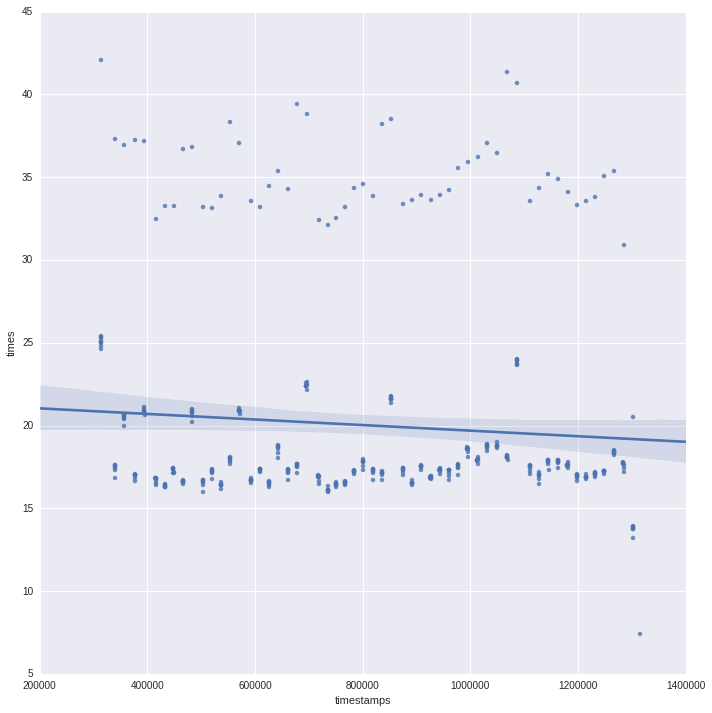

In [5]:
c.execute('SELECT * FROM block_times where runid=(select max(runid) from runs)')
rows = c.fetchall()
rid = (rows[0][2],)

c.execute('SELECT * FROM runs where runid=?', rid)
config = c.fetchone()
config = map(str, config)
names = [i[0] for i in c.description]

timestamps = []
times = []
for row in rows:
    timestamps.append(row[0])
    times.append(row[1])

timedf = pd.DataFrame.from_dict({'timestamps' : timestamps, 'times' : times})
fg = sns.lmplot("timestamps", "times", data=timedf, size=10)
#fg.ax.text(0.005, 0.005, str(zip(names, config)))
print zip(names, config)

#### Timeseries of file times for most recent run

[('runid', '264'), ('node_count', '10'), ('visibility_delay', '0'), ('query_delay', '0'), ('block_size', '262144'), ('deadline', '60.0'), ('latency', '0.0'), ('bandwidth', '1000.0'), ('duration', '1324723905'), ('dup_blocks', '0'), ('workload', './samples/star')]


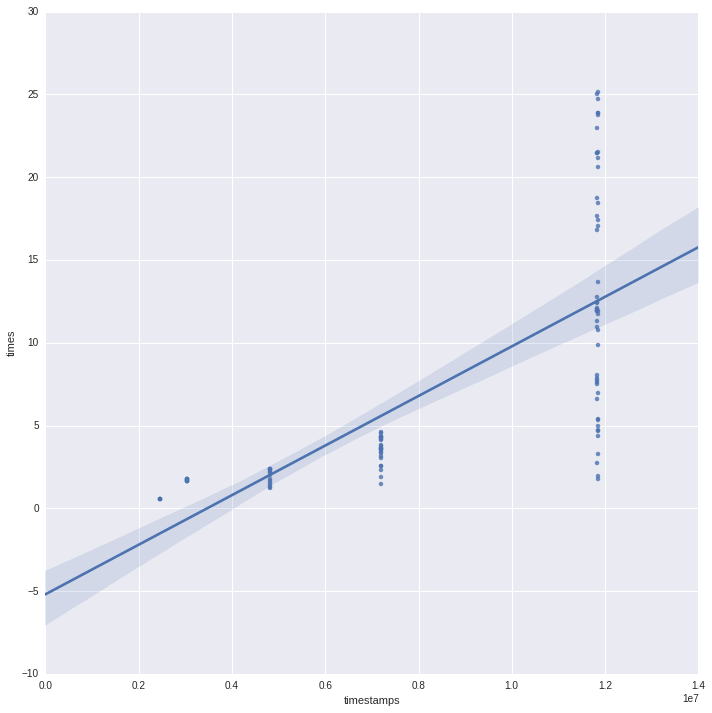

In [9]:
c.execute('SELECT * FROM file_times where runid=(select max(runid) from runs)')
rows = c.fetchall()
rid = (rows[0][2],)

timestamps = []
times = []
for row in rows:
    timestamps.append(row[0])
    times.append(row[1])

timedf = pd.DataFrame.from_dict({'timestamps' : timestamps, 'times' : times})
fg = sns.lmplot("timestamps", "times", data=timedf, size=10)
#fg.ax.text(0.005, 0.005, str(zip(names, config)))
print zip(names, config)

#### Latency vs Mean Block Times at fixed bandwidths

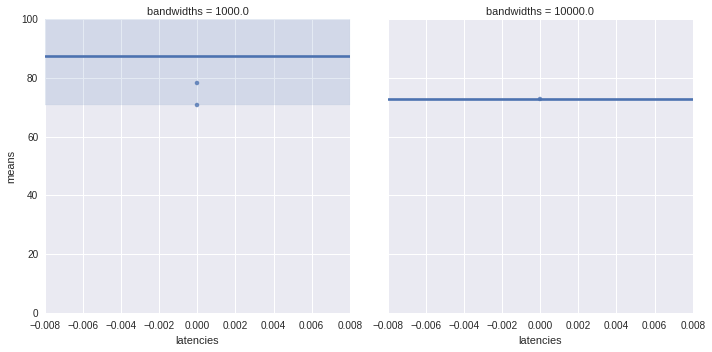

In [7]:
vbw = [1000, 40, 10000]
filter = df['bandwidths'].isin(vbw)
filtered = df[filter]
fg = sns.lmplot("latencies", "means", data=filtered[['latencies', 'means', 'bandwidths']], scatter=True, col="bandwidths")
fg.set(ylim=(0, 100))